# TID2013 Training

In [33]:
!apt-get -qq install pv
!pip install torchinfo

In [34]:
from google.colab import drive
from google.colab import files
from PIL import Image
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import os, json, glob
import os, json, numpy as np
import os, json, random
import os, torch
import random
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision.transforms as T
import torchvision.transforms as transforms
import zipfile

## Load and split data

Load the metadata from the JSON file and split it into training and testing sets. Save the split metadata into `train.json` and `test.json`.

In [35]:
drive.mount('/content/drive')

DATASET_PATH = "/content/drive/MyDrive/Samsung_Project/tid2013"
REF_PATH = os.path.join(DATASET_PATH, "reference_images")
DIST_PATH = os.path.join(DATASET_PATH, "distorted_images")
MOS_FILE = os.path.join(DATASET_PATH, "mos_with_names.txt")
PATCHES_PATH = "/content/drive/MyDrive/Samsung_Project/tid2013_patches"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Sanity check on dataset and patches

In [36]:
# Check if the dataset directory exists and contains files
if os.path.exists(DATASET_PATH) and os.listdir(DATASET_PATH):
    print(f"Dataset directory '{DATASET_PATH}' exists and contains files.")
else:
    print(f"Error: Dataset directory '{DATASET_PATH}' not found or empty.")

# Check if reference and distorted image directories exist and contain files
if os.path.exists(REF_PATH) and os.listdir(REF_PATH):
    print(f"Reference images directory '{REF_PATH}' exists and contains files.")
else:
    print(f"Error: Reference images directory '{REF_PATH}' not found or empty.")

if os.path.exists(DIST_PATH) and os.listdir(DIST_PATH):
    print(f"Distorted images directory '{DIST_PATH}' exists and contains files.")
else:
    print(f"Error: Distorted images directory '{DIST_PATH}' not found or empty.")

# Check if MOS file exists
if os.path.exists(MOS_FILE):
    print(f"MOS file '{MOS_FILE}' found.")
else:
    print(f"Error: MOS file '{MOS_FILE}' not found.")

# Check if patches directory exists (it will be created later, so this is just a check)
if os.path.exists(PATCHES_PATH):
    print(f"Patches directory '{PATCHES_PATH}' exists.")
else:
    print(f"Patches directory '{PATCHES_PATH}' does not exist")

# Display a few image file names to confirm data is there
if os.path.exists(REF_PATH) and os.listdir(REF_PATH):
    print("\nSample reference image files:")
    print(random.sample(os.listdir(REF_PATH), min(5, len(os.listdir(REF_PATH)))))

if os.path.exists(DIST_PATH) and os.listdir(DIST_PATH):
    print("\nSample distorted image files:")
    print(random.sample(os.listdir(DIST_PATH), min(5, len(os.listdir(DIST_PATH)))))

# Display a few image file names from tid2013_patches/copy
COPY_PATCHES_PATH = os.path.join(PATCHES_PATH, "copy")
if os.path.exists(COPY_PATCHES_PATH) and os.listdir(COPY_PATCHES_PATH):
    print(f"\nSample patch files from {COPY_PATCHES_PATH}:")
    print(random.sample(os.listdir(COPY_PATCHES_PATH), min(5, len(os.listdir(COPY_PATCHES_PATH)))))
elif os.path.exists(COPY_PATCHES_PATH):
     print(f"\nDirectory '{COPY_PATCHES_PATH}' is empty.")
else:
    print(f"\nDirectory '{COPY_PATCHES_PATH}' does not exist.")

# Read a few lines of the MOS file
if os.path.exists(MOS_FILE):
    print("\nSample lines from MOS file:")
    with open(MOS_FILE, 'r') as f:
        for i, line in enumerate(f):
            print(line.strip())
            if i >= 4: # Print first 5 lines
                break

Dataset directory '/content/drive/MyDrive/Samsung_Project/tid2013' exists and contains files.
Reference images directory '/content/drive/MyDrive/Samsung_Project/tid2013/reference_images' exists and contains files.
Distorted images directory '/content/drive/MyDrive/Samsung_Project/tid2013/distorted_images' exists and contains files.
MOS file '/content/drive/MyDrive/Samsung_Project/tid2013/mos_with_names.txt' found.
Patches directory '/content/drive/MyDrive/Samsung_Project/tid2013_patches' exists.

Sample reference image files:
['I01.BMP', 'I12.BMP', 'I09.BMP', 'I04.BMP', 'I23.BMP']

Sample distorted image files:
['i11_22_3.bmp', 'i17_18_1.bmp', 'i16_20_2.bmp', 'i05_05_4.bmp', 'i01_06_2.bmp']

Sample patch files from /content/drive/MyDrive/Samsung_Project/tid2013_patches/copy:
['copy_patch_1144.png', 'copy_patch_1322.png', 'copy_patch_0198.png', 'copy_patch_0179.png', 'copy_patch_1740.png']

Sample lines from MOS file:
5.51429 I01_01_1.bmp
5.56757 i01_01_2.bmp
4.94444 i01_01_3.bmp
4.3783

In [37]:
# Load the metadata from the patches directory
# Corrected path to look directly in PATCHES_PATH
metadata_path = os.path.join(PATCHES_PATH, "metadata.json")
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Extract data points
data_points = metadata

# Split data points into training and testing sets
train_data, test_data = train_test_split(data_points, test_size=0.2, random_state=42)

# Create dictionaries for training and testing sets
train_metadata = {'data': train_data}
test_metadata = {'data': test_data}

# Define the output paths for the split metadata files within the patches directory
# Corrected paths to save directly in PATCHES_PATH
train_json_path = os.path.join(PATCHES_PATH, "train.json")
test_json_path = os.path.join(PATCHES_PATH, "test.json")

# Save training metadata to train.json in the patches directory
with open(train_json_path, 'w') as f:
    json.dump(train_metadata, f, indent=4)

# Save testing metadata to test.json in the patches directory
with open(test_json_path, 'w') as f:
    json.dump(test_metadata, f, indent=4)

print(f"Train metadata saved to: {train_json_path}")
print(f"Test metadata saved to: {test_json_path}")

Train metadata saved to: /content/drive/MyDrive/Samsung_Project/tid2013_patches/train.json
Test metadata saved to: /content/drive/MyDrive/Samsung_Project/tid2013_patches/test.json


## Implement dataset loader

Create a custom dataset loader that reads the image pairs and scores from the split metadata files.

In [38]:
class ImagePairDataset(Dataset):
    def __init__(self, metadata_file, img_dir):
        """
        Args:
            metadata_file (string): Path to the json file with annotations.
            img_dir (string): Directory with all the images.
        """
        with open(metadata_file, 'r') as f:
            self.metadata = json.load(f)['data']
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])


    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_info = self.metadata[idx]
        ref_img_name = img_info['reference_image']
        dist_img_name = img_info['distorted_image']
        score = img_info['score']

        ref_img_path = os.path.join(self.img_dir, ref_img_name)
        dist_img_path = os.path.join(self.img_dir, dist_img_name)

        ref_image = Image.open(ref_img_path)
        dist_image = Image.open(dist_img_path)

        # Apply transformations
        ref_image = self.transform(ref_image)
        dist_image = self.transform(dist_image)

        return ref_image, dist_image, score

# Example usage
train_dataset = ImagePairDataset(metadata_file=os.path.join(PATCHES_PATH, 'train.json'), img_dir='/content/drive/MyDrive/Samsung_Project/tid2013_patches/copy')
test_dataset = ImagePairDataset(metadata_file=os.path.join(PATCHES_PATH, 'test.json'), img_dir='/content/drive/MyDrive/Samsung_Project/tid2013_patches/copy')

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 1600
Number of testing samples: 400


## Implement the model

Define the CNN model architecture as described in the prompt.

# PatchDiff-GAP (20×20) – 6-ch CNN Regressor

In [39]:
# Define hyperparameters
batch_size = 16 # Reduced batch size
learning_rate = 0.001
num_epochs = 15 # Increased epochs slightly to compensate for smaller batch size, but early stopping will prevent overfitting
patience = 5 # Increased patience for early stopping
min_delta = 0.0005 # Reduced minimum delta for early stopping

# Updated ImagePairDatasetPatches to load distorted patches and generate reference patches on the fly
class ImagePairDatasetPatches(Dataset):
    def __init__(self, metadata_file, patch_dir, ref_img_original_dir):
        """
        Args:
            metadata_file (string): Path to the json file with annotations.
            patch_dir (string): Directory with all the distorted patches (unique_sample_id).
            ref_img_original_dir (string): Directory with original reference images (clean_image).
        """
        with open(metadata_file, 'r') as f:
            self.metadata = json.load(f)['data']
        self.patch_dir = patch_dir
        self.ref_img_original_dir = ref_img_original_dir
        self.transform = transforms.Compose([
            transforms.ToTensor(), # Keep as RGB (3 channels)
        ])
        # Create a case-insensitive mapping of filenames in the reference directory
        self.ref_filenames_lower = {filename.lower(): filename for filename in os.listdir(ref_img_original_dir)}


    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_info = self.metadata[idx]
        try:
            patch_filename = img_info['unique_sample_id']
            original_ref_img_name = img_info['clean_image']
            roi = img_info['metadata']['roi']
            score = img_info['score']
        except KeyError as e:
            print(f"KeyError: {e}. Available keys in metadata entry: {img_info.keys()}")
            if 'metadata' in img_info and 'roi' not in img_info['metadata']:
                 print(f"KeyError: 'roi' not found in metadata['metadata']. Available keys in 'metadata': {img_info['metadata'].keys()}")
            raise # Re-raise the exception after printing keys
        except Exception as e:
            print(f"An unexpected error occurred while accessing metadata for index {idx}: {e}")
            raise


        # Construct path to the distorted patch file
        dist_patch_path = os.path.join(self.patch_dir, patch_filename)

        # Construct path to the original reference image using case-insensitive lookup
        original_ref_img_name_lower_from_metadata = original_ref_img_name.lower()
        if original_ref_img_name_lower_from_metadata in self.ref_filenames_lower:
            actual_ref_img_name = self.ref_filenames_lower[original_ref_img_name_lower_from_metadata]
            original_ref_img_path = os.path.join(self.ref_img_original_dir, actual_ref_img_name)
        else:
            # If the file is not found even with case-insensitive lookup, raise an error
            raise FileNotFoundError(f"Original reference image '{original_ref_img_name}' (case-insensitive) not found in directory '{self.ref_img_original_dir}'.")


        try:
            # Load the distorted patch
            dist_patch = Image.open(dist_patch_path).convert('RGB') # Ensure RGB
            original_ref_img = Image.open(original_ref_img_path).convert('RGB')
            ref_patch = original_ref_img.crop((roi[0], roi[1], roi[0] + roi[2], roi[1] + roi[3]))


        except FileNotFoundError as e:
            print(f"FileNotFoundError: Could not find image file. Details: {e}")
            print(f"Attempted paths: Distorted patch: {dist_patch_path}, Original reference image: {original_ref_img_path}")
            raise
        except IndexError:
             print(f"IndexError: Invalid ROI format for entry {idx}. ROI: {roi}")
             raise
        except Exception as e:
            print(f"An unexpected error occurred while loading/processing images for index {idx}: {e}")
            print(f"Attempted paths: Distorted patch: {dist_patch_path}, Original reference image: {original_ref_img_path}")
            raise


        # Apply transformations
        ref_patch = self.transform(ref_patch)
        dist_patch = self.transform(dist_patch)

        # Stack the reference and distorted patches along the channel dimension
        stacked_patches = torch.cat([ref_patch, dist_patch], dim=0) # Stack along channel dim (C, H, W) -> (6, H, W)

        return stacked_patches, score

# Instantiate the ImagePairDataset for the training data (using patches and original ref images)
patches_dir_path = os.path.join(PATCHES_PATH, "copy")
train_dataset = ImagePairDatasetPatches(metadata_file=os.path.join(PATCHES_PATH, 'train.json'), patch_dir=patches_dir_path, ref_img_original_dir=REF_PATH)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Implement the new TinyPatchRegressor model
class TinyPatchRegressor(nn.Module):
    def __init__(self, in_channels=6, use_groupnorm=True): # Input channels should be 6 for stacked RGB patches
        super().__init__()
        # 20x20-safe (padding keeps spatial size)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.n1 = nn.GroupNorm(8, 32) if use_groupnorm else nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 16, kernel_size=1)
        self.n2 = nn.GroupNorm(4, 16) if use_groupnorm else nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)  # keep some channels before GAP

        self.gap = nn.AdaptiveAvgPool2d(1)  # -> [B,8,1,1]
        self.dropout = nn.Dropout(0.10)
        self.fc = nn.Linear(8, 1)           # linear head; no sigmoid

        # Kaiming init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.n1(self.conv1(x)))
        x = F.relu(self.n2(self.conv2(x)))
        x = F.relu(self.conv3(x))                 # [B,8,20,20]
        x = self.gap(x).view(x.size(0), 8)        # [B,8]
        x = self.dropout(x)
        x = self.fc(x).squeeze(1)                 # [B]
        return x

model = TinyPatchRegressor(in_channels=6) # Initialize with 6 input channels


print("Model architecture:")
print(model)


# 3. Define the Mean Squared Error (MSE) loss function
criterion = nn.MSELoss()

# 4. Define an optimizer (Adam) and specify the learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 5. Implement the training loop
print(f"\nStarting training for {num_epochs} epochs...")

best_loss = float('inf')
epochs_no_improve = 0

# Initialize the gradient scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Define input_shape for torchinfo summary
input_shape = (batch_size, 6, 20, 20)


for epoch in range(num_epochs):
    running_loss = 0.0
    model.train() # Set model to training mode
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [stacked_patches, scores]
        inputs, scores = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Mixed precision training
        with torch.cuda.amp.autocast():
            # Forward pass
            outputs = model(inputs)

            # Calculate the MSE loss
            # The TinyPatchRegressor outputs a single value (no sigmoid), so scores should match its shape [B]
            scores = scores.float() # Ensure scores are float, shape [B]

            loss = criterion(outputs, scores)

        # Backward pass and optimize with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate running loss
        running_loss += loss.item()

    # Print average loss for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Early stopping check (using training loss - ideally use validation loss)
    if epoch_loss < best_loss - min_delta:
        best_loss = epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs due to no improvement in training loss.")
            break # Stop training loop

print("Finished Training")

print("Model Summary:")
torchinfo.summary(model, input_size=input_shape)

Model architecture:
TinyPatchRegressor(
  (conv1): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (n1): GroupNorm(8, 32, eps=1e-05, affine=True)
  (conv2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (n2): GroupNorm(4, 16, eps=1e-05, affine=True)
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AdaptiveAvgPool2d(output_size=1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

Starting training for 15 epochs...


/tmp/ipython-input-2043045381.py:152: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-2043045381.py:169: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/15, Loss: 0.0449
Epoch 2/15, Loss: 0.0288
Epoch 3/15, Loss: 0.0262
Epoch 4/15, Loss: 0.0260
Epoch 5/15, Loss: 0.0248
Epoch 6/15, Loss: 0.0237
Epoch 7/15, Loss: 0.0240
Epoch 8/15, Loss: 0.0229
Epoch 9/15, Loss: 0.0215
Epoch 10/15, Loss: 0.0204
Epoch 11/15, Loss: 0.0192
Epoch 12/15, Loss: 0.0174
Epoch 13/15, Loss: 0.0170
Epoch 14/15, Loss: 0.0158
Epoch 15/15, Loss: 0.0154
Finished Training
Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
TinyPatchRegressor                       [16]                      --
├─Conv2d: 1-1                            [16, 32, 20, 20]          1,760
├─GroupNorm: 1-2                         [16, 32, 20, 20]          64
├─Conv2d: 1-3                            [16, 16, 20, 20]          528
├─GroupNorm: 1-4                         [16, 16, 20, 20]          32
├─Conv2d: 1-5                            [16, 8, 20, 20]           1,160
├─AdaptiveAvgPool2d: 1-6                 [16, 8, 1, 1]             --
├─Dropout: 1-7                           [16, 8]                   --
├─Linear: 1-8                            [16, 1]                   9
Total params: 3,553
Trainable params: 3,553
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 22.07
Input size (MB): 0.15
Forward/backward pass size (MB): 5.32
Params size (MB): 0.01
Estimated Total Size (MB): 5.49

In [40]:
# 1. Instantiate the ImagePairDataset for the testing data and create a DataLoader
# Corrected metadata_file path to look directly in PATCHES_PATH
patches_dir = os.path.join(PATCHES_PATH, "copy")
# Added the missing ref_img_original_dir argument
test_dataset = ImagePairDatasetPatches(metadata_file=os.path.join(PATCHES_PATH, 'test.json'), patch_dir=patches_dir, ref_img_original_dir=REF_PATH)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle test data

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set the model to evaluation mode and move it to the selected device
model.eval()
model.to(device)


running_loss = 0.0
total_samples = 0

print("\nStarting evaluation on the test set...")

# Disable gradient calculation for evaluation
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [stacked_patches, scores]
        # Corrected data unpacking to match the dataset's output
        inputs, scores = data

        # Move inputs and scores to the selected device
        inputs = inputs.to(device)
        scores = scores.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the MSE loss
        # The TinyPatchRegressor outputs a single value (no sigmoid), so scores should match its shape [B]
        scores = scores.float() # Ensure scores are float, shape [B]

        loss = criterion(outputs, scores)

        # Accumulate running loss and total samples
        running_loss += loss.item() * inputs.size(0) # Multiply by batch size to get sum of losses
        total_samples += inputs.size(0)

# Calculate average loss for the test set
average_test_loss = running_loss / total_samples
print(f"Average Test Loss: {average_test_loss:.4f}")

Using device: cuda

Starting evaluation on the test set...
Average Test Loss: 0.0125


In [41]:
drive.mount('/content/drive', force_remount=True)

save_dir = "/content/drive/MyDrive/Samsung/src/saves"
os.makedirs(save_dir, exist_ok=True)
CKPT_PATH = os.path.join(save_dir, "tinypatchregressor_tid2013_best.pth")

torch.save(model.state_dict(), CKPT_PATH)
print("Saved:", CKPT_PATH)

Mounted at /content/drive
Saved: /content/drive/MyDrive/Samsung/src/saves/tinypatchregressor_tid2013_best.pth


# Samsung inference

In [42]:
zip_file_path = "/content/drive/MyDrive/Samsung_Datasets/dataset.zip"
extract_path = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted"

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    print(f"Error: Zip file not found at '{zip_file_path}'")
else:
    print(f"Zip file found at '{zip_file_path}'")
    # Check if the extraction directory exists and is not empty
    if os.path.exists(extract_path) and os.listdir(extract_path):
        print(f"Extraction directory '{extract_path}' already exists and is not empty. Skipping extraction.")
    else:
        # Create the extraction directory if it doesn't exist
        os.makedirs(extract_path, exist_ok=True)
        print(f"Extraction directory '{extract_path}' not found or is empty. Starting extraction...")
        try:
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Successfully extracted '{zip_file_path}' to '{extract_path}'")
        except Exception as e:
            print(f"Error during extraction: {e}")

Zip file found at '/content/drive/MyDrive/Samsung_Datasets/dataset.zip'
Extraction directory '/content/drive/MyDrive/Samsung_Datasets/dataset_extracted' already exists and is not empty. Skipping extraction.


In [43]:
folder_path = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset"

if os.path.exists(folder_path):
    print(f"Contents of '{folder_path}':")
    for item in os.listdir(folder_path):
        print(item)
else:
    print(f"Error: Folder not found at '{folder_path}'")

Contents of '/content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset':
dataset_metadata.json
clean
new
ref
psnr_table.csv
test_metadata.json
train_metadata.json


In [44]:
base_folder = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset"
subfolders_to_check = ["clean", "new", "ref"]
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff'] # Common image file extensions

for subfolder_name in subfolders_to_check:
    subfolder_path = os.path.join(base_folder, subfolder_name)
    if os.path.exists(subfolder_path) and os.path.isdir(subfolder_path):
        image_count = 0
        for item in os.listdir(subfolder_path):
            if os.path.isfile(os.path.join(subfolder_path, item)):
                # Check if the file has a common image extension (case-insensitive)
                if any(item.lower().endswith(ext) for ext in image_extensions):
                    image_count += 1
        print(f"Number of image files in '{subfolder_name}': {image_count}")
    else:
        print(f"Error: Subfolder '{subfolder_name}' not found or is not a directory at '{subfolder_path}'")

Number of image files in 'clean': 1849
Number of image files in 'new': 1849
Number of image files in 'ref': 1849


In [45]:
# ==== PATHS (Samsung) ====

base_folder = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset"  # <- your root
SAMSUNG_ROOT = base_folder

def looks_like_samsung_meta(p):
    try:
        with open(p, "r") as f:
            js = json.load(f)
        rec = js[0] if isinstance(js, list) and js else (js.get("data", [None])[0] if isinstance(js, dict) else None)
        if not rec: return False
        return ("clean_image" in rec) and ("distorted_image" in rec) and ("metadata" in rec)
    except Exception:
        return False

SAMSUNG_TEST_META = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset/test_metadata.json"

# Trained TID2013 checkpoint
CKPT_PATH = "/content/drive/MyDrive/Samsung/src/saves/tinypatchregressor_tid2013_best.pth"

print("SAMSUNG_ROOT     :", SAMSUNG_ROOT)
print("SAMSUNG_TEST_META:", SAMSUNG_TEST_META)
print("CKPT_PATH        :", CKPT_PATH)

SAMSUNG_ROOT     : /content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset
SAMSUNG_TEST_META: /content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset/test_metadata.json
CKPT_PATH        : /content/drive/MyDrive/Samsung/src/saves/tinypatchregressor_tid2013_best.pth


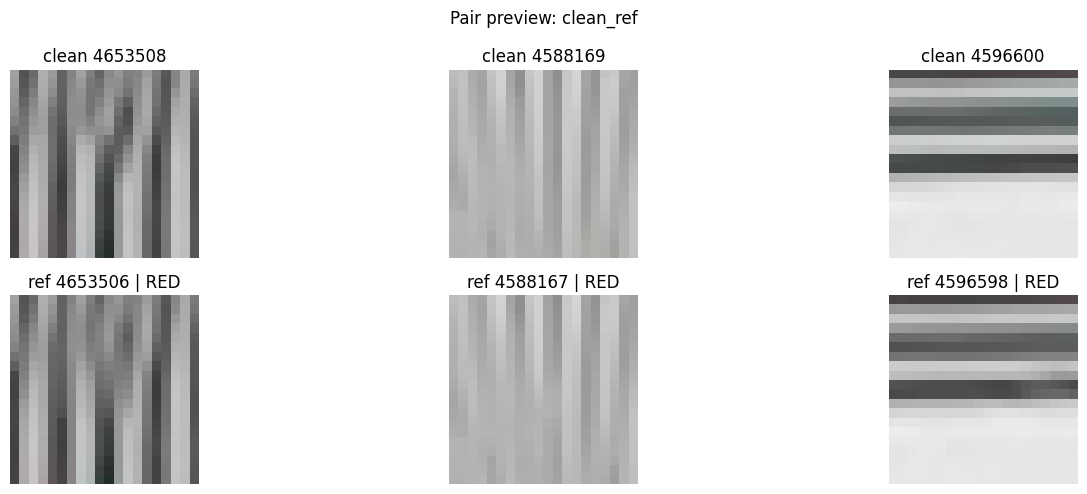

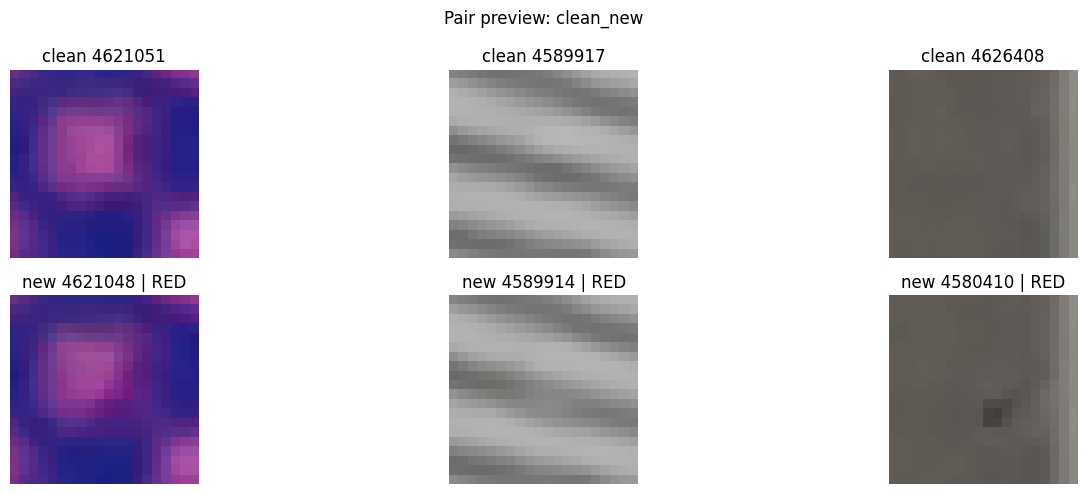

In [46]:
# Pair-aware preview using existing base_folder
base_folder = "/content/drive/MyDrive/Samsung_Datasets/dataset_extracted/dataset"
SAMSUNG_TEST_META = os.path.join(base_folder, "test_metadata.json")
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

def dir_map(d):
    return {os.path.splitext(f)[0]: os.path.join(d, f)
            for f in os.listdir(d)
            if os.path.splitext(f)[1].lower() in image_extensions and os.path.isfile(os.path.join(d,f))}

clean_map = dir_map(os.path.join(base_folder, "clean"))
ref_map   = dir_map(os.path.join(base_folder, "ref"))
new_map   = dir_map(os.path.join(base_folder, "new"))

with open(SAMSUNG_TEST_META, "r") as f:
    rows = json.load(f)

def sample_and_show(pair_type="clean_ref", k=3):
    want = "ref" if pair_type=="clean_ref" else "new"
    subset = [r for r in rows if str(r.get("metadata",{}).get("method","")).lower()==want]
    subset = random.sample(subset, min(k, len(subset)))
    plt.figure(figsize=(5*k, 5))
    for i, r in enumerate(subset, 1):
        clean_id = str(r["clean_image"])
        dist_id  = str(r["distorted_image"])
        label    = str(r.get("metadata",{}).get("color","?")).upper()

        p_clean = clean_map.get(clean_id)
        p_other = (ref_map if want=="ref" else new_map).get(dist_id)
        if not (p_clean and p_other):
            print("Missing:", r.get("unique_sample_id")); continue

        ax1 = plt.subplot(2, k, i);     ax1.imshow(Image.open(p_clean)); ax1.set_title(f"clean {clean_id}"); ax1.axis("off")
        ax2 = plt.subplot(2, k, i+k);   ax2.imshow(Image.open(p_other)); ax2.set_title(f"{want} {dist_id} | {label}"); ax2.axis("off")
    plt.suptitle(f"Pair preview: {pair_type}"); plt.tight_layout(); plt.show()

sample_and_show("clean_ref", k=3)
sample_and_show("clean_new", k=3)

In [47]:
state = torch.load(CKPT_PATH, map_location="cpu")
sd = state.get("state_dict", state)
model = TinyPatchRegressor(in_channels=6)
model.load_state_dict(sd, strict=False)

<All keys matched successfully>

# Loader + helpers

In [48]:
LBL_MAP = {"GREEN":0, "ORANGE":1, "RED":2}
TO_T = T.ToTensor()              # training used ToTensor only
READ = lambda p: TO_T(Image.open(p).convert("RGB"))
EXTS = {".png",".bmp",".jpg",".jpeg",".tiff"}

def _dir_map(folder: str):
    return {os.path.splitext(f)[0]: os.path.join(folder, f)
            for f in os.listdir(folder)
            if os.path.splitext(f)[1].lower() in EXTS and os.path.isfile(os.path.join(folder,f))}

class SamsungIDDataset(Dataset):
    """Emits X=[6,H,W] stacked as [clean/reference, distorted], y in {0,1,2}."""
    def __init__(self, meta_json: str, root: str, pair_type: str, order: str="clean_other"):
        assert pair_type in ("clean_ref","clean_new") and order in ("clean_other","dist_ref")
        rows = json.load(open(meta_json))
        want = "ref" if pair_type=="clean_ref" else "new"
        self.rows = [r for r in rows if str(r["metadata"]["method"]).lower()==want]
        self.clean = _dir_map(os.path.join(root, "clean"))
        self.ref   = _dir_map(os.path.join(root, "ref"))
        self.new   = _dir_map(os.path.join(root, "new"))
        self.order = order
    def __len__(self): return len(self.rows)
    def _resolve(self, mp, fid):  # fid is int or str id
        k = str(fid)
        if k in mp: return mp[k]
        for p in ("","clean_","ref_","new_"):
            if p+k in mp: return mp[p+k]
        raise FileNotFoundError(f"Missing {k}")
    def __getitem__(self, i):
        r = self.rows[i]; m = r["metadata"]; rid = str(r.get("unique_sample_id", i))
        pc = self._resolve(self.clean, r["clean_image"])
        po = self._resolve(self.ref if m["method"].lower()=="ref" else self.new, r["distorted_image"])
        try:
            clean, other = READ(pc), READ(po)
        except (FileNotFoundError, UnidentifiedImageError) as e:
            raise FileNotFoundError(f"{e}\nclean={pc}\nother={po}\nrec={rid}")
        x = torch.cat([clean, other], 0) if self.order=="clean_other" else torch.cat([other, clean], 0)
        y = LBL_MAP.get(str(m["color"]).upper(), -1)
        return x, y, rid

def run_inference_6ch(model, loader, device, apply_sigmoid=False, invert=True):
    model.eval(); preds=[]; ys=[]; ids=[]
    with torch.no_grad():
        for xb,yb,rid in loader:
            z = model(xb.to(device).float()).squeeze()
            s = torch.sigmoid(z) if apply_sigmoid else z
            s = s.clamp(0,1)
            if invert: s = 1.0 - s
            preds.append(s.cpu().numpy()); ys.append(yb.numpy()); ids += list(rid)
    return np.concatenate(preds), np.concatenate(ys), ids

def eval_with_bins(y_true, scores01, b1=0.3, b2=0.6, title=""):
    m = (y_true>=0); y, s = y_true[m], scores01[m]
    pred = np.digitize(s, [b1,b2])
    cm = confusion_matrix(y, pred, labels=[0,1,2])
    acc = accuracy_score(y, pred); bacc = balanced_accuracy_score(y, pred)
    if title: print(title)
    print("CM (rows=true, cols=pred):\n", cm)
    print(f"Acc: {acc:.3f} | BAcc: {bacc:.3f}")
    print(classification_report(y, pred, labels=[0,1,2], target_names=["GREEN","ORANGE","RED"], digits=3))
    return cm, acc, bacc

# Run

In [49]:
# ---- RUN ----
BATCH = 128
NUM_WORKERS = 2 if torch.cuda.is_available() else 0
ORDER = "clean_other"     # match training: [clean/reference, distorted]
APPLY_SIGMOID = False     # trained without sigmoid
DO_INVERT = True          # quality -> severity

make_loader = lambda meta, typ: DataLoader(
    SamsungIDDataset(meta, SAMSUNG_ROOT, pair_type=typ, order=ORDER),
    batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)
dl_ref = make_loader(SAMSUNG_TEST_META, "clean_ref")
dl_new = make_loader(SAMSUNG_TEST_META, "clean_new")
print(f"(clean,ref)={len(dl_ref.dataset)} | (clean,new)={len(dl_new.dataset)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyPatchRegressor(in_channels=6).to(device)
state = torch.load(CKPT_PATH, map_location="cpu")
sd = state["state_dict"] if isinstance(state, dict) and "state_dict" in state else state
missing, unexpected = model.load_state_dict(sd, strict=True)
print("missing:", missing, "| unexpected:", unexpected)

pred_ref, y_ref, _ = run_inference_6ch(model, dl_ref, device, apply_sigmoid=APPLY_SIGMOID, invert=DO_INVERT)
pred_new, y_new, _ = run_inference_6ch(model, dl_new, device, apply_sigmoid=APPLY_SIGMOID, invert=DO_INVERT)

def q(a): return np.percentile(a,[0,5,25,50,75,95,100])
print("REF quantiles:", q(pred_ref)); print("NEW quantiles:", q(pred_new))

print("\n=== Official cuts (0.3/0.6) ===")
_ = eval_with_bins(y_ref, pred_ref, 0.3, 0.6, "TEST (clean,ref)")
_ = eval_with_bins(y_new, pred_new, 0.3, 0.6, "TEST (clean,new)")

(clean,ref)=381 | (clean,new)=359
missing: [] | unexpected: []
REF quantiles: [0.36936665 0.4139204  0.46998119 0.48903829 0.50842732 0.55124861
 0.65340036]
NEW quantiles: [0.36993033 0.42664171 0.46790755 0.49072981 0.51455691 0.5605104
 0.66656446]

=== Official cuts (0.3/0.6) ===
TEST (clean,ref)
CM (rows=true, cols=pred):
 [[  0 109   2]
 [  0  79   2]
 [  0 187   2]]
Acc: 0.213 | BAcc: 0.329
              precision    recall  f1-score   support

       GREEN      0.000     0.000     0.000       111
      ORANGE      0.211     0.975     0.346        81
         RED      0.333     0.011     0.021       189

    accuracy                          0.213       381
   macro avg      0.181     0.329     0.122       381
weighted avg      0.210     0.213     0.084       381

TEST (clean,new)
CM (rows=true, cols=pred):
 [[  0 113   0]
 [  0  46   0]
 [  0 192   8]]
Acc: 0.150 | BAcc: 0.347
              precision    recall  f1-score   support

       GREEN      0.000     0.000     0.000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

# Calibration (perpairing)

TRAIN calib REF: b1=0.520, b2=0.618, BAcc=0.345
TRAIN calib NEW: b1=0.516, b2=0.600, BAcc=0.419

[Samsung TEST (clean, ref)]  Acc=0.2205 | Macro P=0.2043 R=0.2887 F1=0.2007

[Samsung TEST (clean, new)]  Acc=0.2981 | Macro P=0.4610 R=0.4026 F1=0.2964


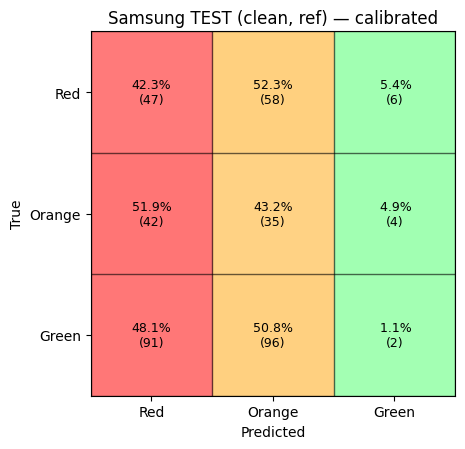

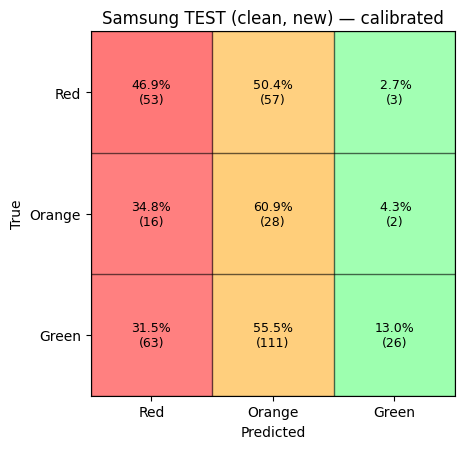

In [32]:
# ==== Calibrate on Samsung TRAIN → apply to TEST; plot CMs with Red/Orange/Green ====
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    balanced_accuracy_score, confusion_matrix, accuracy_score,
    precision_recall_fscore_support
)

# ----------------- TRAIN: loaders + inference -----------------
SAMSUNG_TRAIN_META = os.path.join(SAMSUNG_ROOT, "train_metadata.json")
dl_ref_tr = make_loader(SAMSUNG_TRAIN_META, "clean_ref")
dl_new_tr = make_loader(SAMSUNG_TRAIN_META, "clean_new")

# NOTE: your run_inference_6ch returns (scores, labels, extra)
ref_tr_s, ref_tr_y, _ = run_inference_6ch(model, dl_ref_tr, device, apply_sigmoid=False, invert=True)
new_tr_s, new_tr_y, _ = run_inference_6ch(model, dl_new_tr, device, apply_sigmoid=False, invert=True)

# ----------------- Calibration on TRAIN -----------------
def calibrate_bins(scores, labels, lo=0.42, hi=0.62, step=0.002):
    """Grid-search bin thresholds (b1<b2) maximizing balanced accuracy on 3-way {0,1,2}."""
    best = (0.33, 0.66, -1.0)
    for b1 in np.arange(lo, hi - 0.01, step):
        for b2 in np.arange(b1 + 0.01, hi, step):
            pred = np.digitize(scores, [b1, b2])        # 0=Red, 1=Orange, 2=Green
            bacc = balanced_accuracy_score(labels, pred)
            if bacc > best[2]:
                best = (float(b1), float(b2), float(bacc))
    return best  # (b1, b2, best_bal_acc)

b1r, b2r, bacc_r = calibrate_bins(ref_tr_s, ref_tr_y)
b1n, b2n, bacc_n = calibrate_bins(new_tr_s, new_tr_y)
print(f"TRAIN calib REF: b1={b1r:.3f}, b2={b2r:.3f}, BAcc={bacc_r:.3f}")
print(f"TRAIN calib NEW: b1={b1n:.3f}, b2={b2n:.3f}, BAcc={bacc_n:.3f}")

# ----------------- Eval helpers -----------------
LABELS   = [0, 1, 2]
NAMES    = ['Red', 'Orange', 'Green']

def row_percent(cm_counts: np.ndarray) -> np.ndarray:
    rs = cm_counts.sum(axis=1, keepdims=True)
    return np.divide(cm_counts, rs, where=rs != 0, out=np.zeros_like(cm_counts, dtype=float))

def eval_split(y_true, scores01, b1, b2):
    y_pred   = np.digitize(scores01, [b1, b2])
    cm_count = confusion_matrix(y_true, y_pred, labels=LABELS)
    cm_pct   = row_percent(cm_count)
    acc      = accuracy_score(y_true, y_pred)
    pM, rM, fM, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', labels=LABELS, zero_division=0)
    pC, rC, fC, sup = precision_recall_fscore_support(y_true, y_pred, labels=LABELS, zero_division=0)
    return {"cm_counts": cm_count, "cm_pct": cm_pct, "acc": acc, "macro": (pM, rM, fM), "per_class": (pC, rC, fC, sup)}

def plot_cm_color(cm_counts, cm_pct, title=''):
    base = np.array([
        [1.00, 0.35, 0.35],  # Red
        [1.00, 0.78, 0.40],  # Orange
        [0.45, 1.00, 0.55],  # Green
    ], dtype=float)

    H, W = cm_counts.shape
    rgb = np.zeros((H, W, 3), float)
    fade = 0.35
    for j in range(W):
        tint = fade + (1 - fade) * base[j]
        pct = cm_pct[:, j][:, None]
        rgb[:, j, :] = (1 - pct) * tint + pct * base[j]

    fig, ax = plt.subplots(figsize=(5.6, 4.6))
    ax.imshow(rgb, interpolation='nearest', aspect='equal')

    for x in range(W + 1):
        ax.axvline(x - 0.5, color='black', linewidth=1.0, alpha=0.6)
    for y in range(H + 1):
        ax.axhline(y - 0.5, color='black', linewidth=1.0, alpha=0.6)

    ax.set(title=title, xlabel='Predicted', ylabel='True', xticks=range(W), yticks=range(H),
           xticklabels=NAMES, yticklabels=NAMES)

    for i in range(H):
        for j in range(W):
            ax.text(j, i, f"{cm_pct[i, j]*100:4.1f}%\n({cm_counts[i, j]})",
                    ha='center', va='center', fontsize=9, color='black')

    ax.set_xlim(-0.5, W - 0.5)
    ax.set_ylim(H - 0.5, -0.5)
    plt.tight_layout()
    plt.show()

# ----------------- Apply to TEST -----------------
res_ref = eval_split(y_ref, pred_ref, b1r, b2r)
res_new = eval_split(y_new, pred_new, b1n, b2n)

for name, res in [("Samsung TEST (clean, ref)", res_ref),
                  ("Samsung TEST (clean, new)", res_new)]:
    pM, rM, fM = res["macro"]
    print(f"\n[{name}]  Acc={res['acc']:.4f} | Macro P={pM:.4f} R={rM:.4f} F1={fM:.4f}")

plot_cm_color(res_ref["cm_counts"], res_ref["cm_pct"], "Samsung TEST (clean, ref) — calibrated")
plot_cm_color(res_new["cm_counts"], res_new["cm_pct"], "Samsung TEST (clean, new) — calibrated")